In [1]:
import xgboost as xgb
import pandas as pd
import sklearn
import numpy as np
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

In [2]:
path1=("MSFT_prices_1m.csv")
msft=pd.read_csv(path1, index_col="Datetime", parse_dates=True, infer_datetime_format=True)
msft

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-07 09:30:00-05:00,314.15,315.00,313.55,314.52,314.52,1266090
2022-01-07 09:31:00-05:00,314.51,315.32,314.33,315.24,315.24,177362
2022-01-07 09:32:00-05:00,315.24,315.28,314.06,314.66,314.66,113985
2022-01-07 09:33:00-05:00,313.50,313.68,313.27,313.56,313.56,112925
2022-01-07 09:34:00-05:00,313.54,314.14,313.26,313.47,313.47,78540
...,...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,302.23,230814
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,302.63,249918
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,302.60,264540


In [3]:
# Select the start of the training period
training_begin = msft.index.min()

# Display the training begin date
print(training_begin)

2022-01-07 09:30:00-05:00


In [4]:
# Select the ending period for the training data with an offset of 3 months
training_end = msft.index.min() + DateOffset(minutes=2500)

# Display the training end date
print(training_end)

2022-01-09 03:10:00-05:00


In [5]:
X_train = msft.loc[training_begin:training_end]
X_train = X_train.drop(columns=["Close"])                   
y_train = msft.loc[training_begin:training_end]
y_train = y_train.drop(columns=["Open","High","Low","Adj Close","Volume"])

In [6]:
# Generate the X_test and y_test DataFrames
X_test1 = msft.loc[training_end:]
X_test = X_test1.drop(columns=["Close"])
y_test = msft.loc[training_end:]
y_test = y_test.drop(columns=["Open","High","Low","Adj Close","Volume"])

# Display sample data
X_test


,Open,High,Low,Adj Close,Volume
Datetime,,,,,
2022-01-10 09:30:00-05:00,309.48,309.87,308.55,309.45,1675793
2022-01-10 09:31:00-05:00,309.40,310.01,308.82,309.42,267799
2022-01-10 09:32:00-05:00,309.35,309.35,308.51,308.69,209162
2022-01-10 09:33:00-05:00,308.73,309.17,308.24,308.38,233834
2022-01-10 09:34:00-05:00,308.00,308.48,307.84,308.48,302050
...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,230814
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,249918
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,264540


In [7]:
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
# specify parameters via map
from xgboost import XGBRegressor
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=4000,
    learning_rate=0.091,
    subsample=0.8,
    colsample_bytree=0.8, 
    max_depth=7)

reg_mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=.8, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.091, max_delta_step=0, max_depth=7,
             min_child_weight=3, monotone_constraints='()',
             n_estimators=4000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.005, reg_lambda=.005, scale_pos_weight=1, subsample=0.,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.091, max_delta_step=0,
             max_depth=7, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=4000, n_jobs=8,
             num_parallel_tree=1, predictor=None, random_state=0,
             reg_alpha=0.005, reg_lambda=0.005, scale_pos_weight=1,
             subsample=0.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [9]:
# make prediction
reg_mod.fit(X_train,y_train)
predictions = reg_mod.predict(X_test)

In [10]:
#Determine the mean squared error for MSFT
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 3.065968


In [11]:
#Determing the R squared score for MSFT
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.799531


In [12]:
#Check Predictions
print(predictions)

[310.28296 310.2831  310.2831  ... 310.2831  310.28296 310.3466 ]


In [13]:
#Add MSFT Predictions to dataframe
X_test1["Predictions"]=predictions
xgb_pred=X_test1
xgb_pred

C:\Users\brand\AppData\Local\Temp/ipykernel_15248/2946956377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1["Predictions"]=predictions


,Open,High,Low,Close,Adj Close,Volume,Predictions
Datetime,,,,,,,
2022-01-10 09:30:00-05:00,309.48,309.87,308.55,309.45,309.45,1675793,310.282959
2022-01-10 09:31:00-05:00,309.40,310.01,308.82,309.42,309.42,267799,310.283112
2022-01-10 09:32:00-05:00,309.35,309.35,308.51,308.69,308.69,209162,310.283112
2022-01-10 09:33:00-05:00,308.73,309.17,308.24,308.38,308.38,233834,310.283112
2022-01-10 09:34:00-05:00,308.00,308.48,307.84,308.48,308.48,302050,310.283112
...,...,...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,302.23,230814,310.283112
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,302.63,249918,310.283112
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,302.60,264540,310.283112


In [14]:
#Add signals to the MSFT dataframe
xgb_pred['Signal'] =0.0
xgb_pred.loc[(xgb_pred['Predictions'] > xgb_pred['Close']), 'Signal']=1
xgb_pred.loc[(xgb_pred['Predictions'] < xgb_pred['Close']), 'Signal']=-1
xgb_pred.to_csv("XGB-MSFT-Pred.csv")

C:\Users\brand\AppData\Local\Temp/ipykernel_15248/1549769460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_pred['Signal'] =0.0
C:\Users\brand\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [15]:
#prepare the MSFT actual and predicted values for visualization
xgb_plot=xgb_pred.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Signal'])
xgb_plot

,Close,Predictions
Datetime,,
2022-01-10 09:30:00-05:00,309.45,310.282959
2022-01-10 09:31:00-05:00,309.42,310.283112
2022-01-10 09:32:00-05:00,308.69,310.283112
2022-01-10 09:33:00-05:00,308.38,310.283112
2022-01-10 09:34:00-05:00,308.48,310.283112
...,...,...
2022-01-18 15:56:00-05:00,302.23,310.283112
2022-01-18 15:57:00-05:00,302.63,310.283112
2022-01-18 15:58:00-05:00,302.60,310.283112


<AxesSubplot:title={'center':'Extreme Gradient Booster MSFT Predictions vs. Reality'}, xlabel='Date', ylabel='Price'>

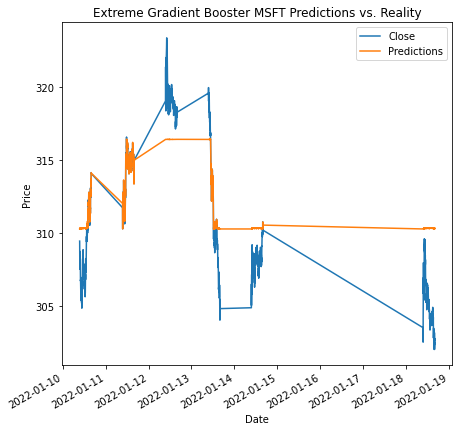

In [16]:
#Visualize MSFT data
xgb_plot.plot(title="Extreme Gradient Booster MSFT Predictions vs. Reality", xlabel ="Date", ylabel="Price", figsize=(7, 7))

In [17]:
#Bring in new data for prediction
eth=pd.read_csv("ETH-USD_prices_5m_January.csv", index_col="Datetime", parse_dates=True, infer_datetime_format=True)
eth

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-06 00:00:00+00:00,3545.65,3545.65,3536.39,3536.39,3536.39,0
2022-01-06 00:05:00+00:00,3536.30,3538.52,3536.30,3538.47,3538.47,52967424
2022-01-06 00:10:00+00:00,3538.58,3538.91,3535.28,3538.91,3538.91,15769600
2022-01-06 00:15:00+00:00,3541.70,3546.87,3541.70,3546.87,3546.87,103151616
2022-01-06 00:20:00+00:00,3544.46,3544.46,3531.40,3531.40,3531.40,405878784
...,...,...,...,...,...,...
2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,2437.05,1313792
2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,2432.26,15685632
2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,2427.48,6836224


In [18]:
#Select the starting period of the training data
eth_begin = eth.index.min()

# Display the training begin date
print(eth_begin)

2022-01-06 00:00:00+00:00


In [19]:
# Select the ending period for the training data
eth_end = eth.index.min() + DateOffset(minutes=5000)

# Display the training end date
print(eth_end)

2022-01-09 11:20:00+00:00


In [20]:
#Establish the ETH training data
eth_X_train = eth.loc[eth_begin:eth_end]
eth_X_train = eth_X_train.drop(columns=["Close"])                   
eth_y_train = eth.loc[eth_begin:eth_end]
eth_y_train = eth_y_train.drop(columns=["Open","High","Low","Adj Close","Volume"])

In [21]:
# Generate the ETH test data
eth_X_test1 = eth.loc[eth_end:]
eth_X_test = eth_X_test1.drop(columns=["Close"])
eth_y_test = eth.loc[eth_end:]
eth_y_test = eth_y_test.drop(columns=["Open","High","Low","Adj Close","Volume"])

# Display sample data
eth_X_test


,Open,High,Low,Adj Close,Volume
Datetime,,,,,
2022-01-09 11:20:00+00:00,3124.81,3124.81,3123.80,3123.95,0
2022-01-09 11:25:00+00:00,3123.98,3124.50,3123.55,3123.55,11421696
2022-01-09 11:30:00+00:00,3123.18,3123.80,3122.44,3123.80,21298176
2022-01-09 11:35:00+00:00,3124.50,3126.61,3124.27,3126.61,5869568
2022-01-09 11:40:00+00:00,3128.11,3128.11,3126.62,3126.81,1794048
...,...,...,...,...,...
2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,1313792
2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,15685632
2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,6836224


In [22]:
#Prep for XGB predictions
eth_dtrain = xgb.DMatrix(eth_X_train, label=eth_y_train)
eth_dtest = xgb.DMatrix(eth_X_test, label=eth_y_test)

In [23]:
#Fit data for XGB Predictions
reg_mod.fit(eth_X_train, eth_y_train)
eth_predictions = reg_mod.predict(eth_X_test)

In [24]:
#determine Mean Squared Error for ETH data
eth_rmse = np.sqrt(mean_squared_error(eth_y_test, eth_predictions))
print("RMSE: %f" % (eth_rmse))

RMSE: 298.332582


In [25]:
#Determine R Squared score for ETH data
eth_r2 = np.sqrt(r2_score(eth_y_test, eth_predictions))
print("R_Squared Score : %f" % (eth_r2))

R_Squared Score : 0.530497


In [26]:
#Check ETH predictions
eth_predictions

array([3123.9512, 3124.2695, 3124.382 , ..., 3021.1753, 3021.9639,
       3021.9639], dtype=float32)

In [27]:
#Add predictions to ETH dataframe
eth_X_test1['Predictions']=eth_predictions
eth_preds=eth_X_test1
eth_preds

C:\Users\brand\AppData\Local\Temp/ipykernel_15248/1902328566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_X_test1['Predictions']=eth_predictions


,Open,High,Low,Close,Adj Close,Volume,Predictions
Datetime,,,,,,,
2022-01-09 11:20:00+00:00,3124.81,3124.81,3123.80,3123.95,3123.95,0,3123.951172
2022-01-09 11:25:00+00:00,3123.98,3124.50,3123.55,3123.55,3123.55,11421696,3124.269531
2022-01-09 11:30:00+00:00,3123.18,3123.80,3122.44,3123.80,3123.80,21298176,3124.382080
2022-01-09 11:35:00+00:00,3124.50,3126.61,3124.27,3126.61,3126.61,5869568,3125.437256
2022-01-09 11:40:00+00:00,3128.11,3128.11,3126.62,3126.81,3126.81,1794048,3126.732910
...,...,...,...,...,...,...,...
2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,2437.05,1313792,3022.227295
2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,2432.26,15685632,3021.292480
2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,2427.48,6836224,3021.175293


In [28]:
eth_preds['Signal'] =0.0
eth_preds.loc[(eth_preds['Predictions'] > eth_preds['Close']), 'Signal']=1
eth_preds.loc[(eth_preds['Predictions'] < eth_preds['Close']), 'Signal']=-1
eth_preds.to_csv("XGB-ETH-Preds.csv")
eth_preds

C:\Users\brand\AppData\Local\Temp/ipykernel_15248/2848294801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_preds['Signal'] =0.0
C:\Users\brand\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Open,High,Low,Close,Adj Close,Volume,Predictions,Signal
Datetime,,,,,,,,
2022-01-09 11:20:00+00:00,3124.81,3124.81,3123.80,3123.95,3123.95,0,3123.951172,1.0
2022-01-09 11:25:00+00:00,3123.98,3124.50,3123.55,3123.55,3123.55,11421696,3124.269531,1.0
2022-01-09 11:30:00+00:00,3123.18,3123.80,3122.44,3123.80,3123.80,21298176,3124.382080,1.0
2022-01-09 11:35:00+00:00,3124.50,3126.61,3124.27,3126.61,3126.61,5869568,3125.437256,-1.0
2022-01-09 11:40:00+00:00,3128.11,3128.11,3126.62,3126.81,3126.81,1794048,3126.732910,-1.0
...,...,...,...,...,...,...,...,...
2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,2437.05,1313792,3022.227295,1.0
2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,2432.26,15685632,3021.292480,1.0
2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,2427.48,6836224,3021.175293,1.0


In [29]:
#Prep ETH data for visualization
eth_preds=eth_preds.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Signal'])
eth_preds

,Close,Predictions
Datetime,,
2022-01-09 11:20:00+00:00,3123.95,3123.951172
2022-01-09 11:25:00+00:00,3123.55,3124.269531
2022-01-09 11:30:00+00:00,3123.80,3124.382080
2022-01-09 11:35:00+00:00,3126.61,3125.437256
2022-01-09 11:40:00+00:00,3126.81,3126.732910
...,...,...
2022-01-26 00:45:00+00:00,2437.05,3022.227295
2022-01-26 00:50:00+00:00,2432.26,3021.292480
2022-01-26 00:55:00+00:00,2427.48,3021.175293


<AxesSubplot:title={'center':'Extreme Gradient Booster ETH Predictions vs. Reality'}, xlabel='Date', ylabel='Price'>

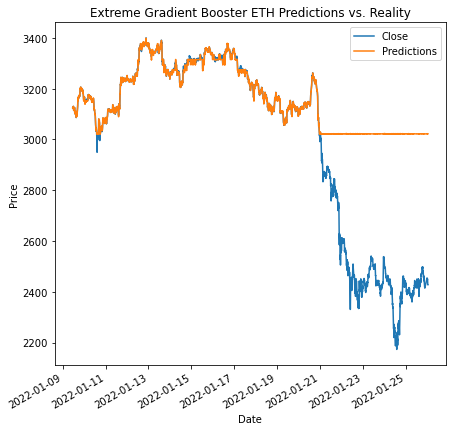

In [30]:
#Visualize ETH Data
eth_preds.plot(title="Extreme Gradient Booster ETH Predictions vs. Reality", xlabel ="Date", ylabel="Price", figsize=(7, 7))